##### Copyright 2019 The TensorFlow Authors.

In [386]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [387]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning with a pretrained ConvNet

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from random import shuffle, randrange
import tensorflow_addons as tfa

In [389]:
import tensorflow as tf
print('Tensorflow version = {}, addons version = {}'.format(tf.__version__, tfa.__version__))
print('Executing eagerly = {}'.format(tf.executing_eagerly()))
keras = tf.keras

tf.random.set_seed(23456)
datetime.now().strftime("%d/%m/%Y %H:%M:%S")

Tensorflow version = 2.1.0, addons version = 0.8.3
Executing eagerly = True


'28/04/2020 23:51:04'

In [390]:
#import tensorflow_addons as tfa
#import tqdm
#tqdm.__version__

## Data preprocessing

### Data download

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [391]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dogs"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, and 10% of the data respectively.

In [392]:
# SPLIT_WEIGHTS = (8, 1, 1)
# splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
# 
# (raw_train, raw_validation, raw_test), metadata = tfds.load(
#     'cats_vs_dogs', split=list(splits),
#     with_info=True, as_supervised=True)

In [393]:
def _tfrecord_dataset_type_from_folder(folder, dataset_type, ext='.tfrecords'):
    tfrecords = [os.path.join(folder, n)
                 for n in os.listdir(folder) if n.startswith(dataset_type) and n.endswith(ext)]
    return tf.data.TFRecordDataset(tfrecords)

num_shards=4
tfdataset_dir="/hdd/data/radioterapia/ciolaplata/tfds.2019.ovs"
donottest=True

raw_train = _tfrecord_dataset_type_from_folder(tfdataset_dir, 'train')
raw_validation = _tfrecord_dataset_type_from_folder(tfdataset_dir, 'validation')
if not donottest:
    raw_test = _tfrecord_dataset_type_from_folder(tfdataset_dir, 'test')

The resulting `tf.data.Dataset` objects contain `(image, label)` pairs where the images have variable shape and 3 channels, and the label is a scalar.

In [394]:
print(raw_train)
print(raw_validation)
if not donottest:
    print(raw_test)

<TFRecordDatasetV2 shapes: (), types: tf.string>
<TFRecordDatasetV2 shapes: (), types: tf.string>


In [395]:
sum(1 for _ in raw_validation)

245

Show the first two images and labels from the training set:

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [396]:
def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].

    :param image:
        Required. Image tensor.

    :return:
        Scaled image.
    """
    # Image must be casted to float32 first
    image = tf.cast(image, tf.float32)
    # Rescale image from [0, 255] to [0, 2], and by substracting -1 we rescale to [-1, 1].
    image = (image/127.5) - 1
    return image

In [397]:
def _parse_image_function(example_proto, img_size, normalization_fn, data_augmentation=False):
    # Create a dictionary describing the features.
    image_feature_description = {"image/filename": tf.io.FixedLenFeature((), tf.string),
                "image/encoded": tf.io.FixedLenFeature((), tf.string),
                "image/format": tf.io.FixedLenFeature((), tf.string),
                "image/gamma_index": tf.io.FixedLenFeature((), tf.float32),
                "image/height": tf.io.FixedLenFeature((), tf.int64),
                "image/width": tf.io.FixedLenFeature((), tf.int64)}

    
    def image_augment(image, gamma):
        if gamma <= 99.2:
            # Apply data augmentations randomly.
            # radian = randrange(4) * 90
            # return tfa.image.transform_ops.rotate(image, radian)
            op = randrange(3)
            if op == 1:
                return tf.image.random_flip_left_right(image)
            elif op == 2:
                return tf.image.random_flip_up_down(image)
            else:
                return image
        else:
            return image
        
        
    # Parse the input tf.Example proto using the dictionary above.
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    
    # print(type(image), image.shape, image.dtype) # <class 'tensorflow.python.framework.ops.Tensor'> (None, None, 3) <dtype: 'uint8'>
    image = tf.image.decode_jpeg(parsed["image/encoded"], channels=3)

    #gamma_index is a tensor of an array of tf.float32
    gamma = tf.cast(
        parsed["image/gamma_index"],
        tf.float32)
    
    if data_augmentation:
        image = image_augment(image, gamma)
        
    image = normalization_fn(image)
    
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    print(type(image), image.shape, image.dtype)
    
    #label is a tensor of an array of single tf.int64 arrays.
    #label = tf.cast(
    #    tf.reshape(parsed["image/class/label"], [-1]),
    #    tf.int64)

    # assert tf.executing_eagerly() FAILS
    # parsed["image/filename"] is a Tensor and not an EagerTensor because we are in a map function,
    # because in 2.0, code inside Datasets maps is turned into a subgraph for speed, just as it was in 1.x eager
    # execution. You generally want to avoid Python inside your data pipeline.
    # So, if I invoke parsed["image/filename"].numpy().decode('utf-8') to get the filename string the error
    # "AttributeError: 'Tensor' object has no attribute 'numpy'" is thrown, hence I return a tensor.
    filename = parsed["image/filename"]
            
    return image, gamma, filename

Apply this function to each item in the dataset using the map method:

In [398]:
IMG_SIZE = 256 # All images will be resized to 160x160
normalization_fn = rescale_min_1_to_1
# normalization_fn = tf.image.per_image_standardization # loss y mae en validación reportan números muy grande,
# no así en training.
data_augmentation=False
add_regularizers=False

In [399]:
num_workers = 8

# assert tf.executing_eagerly()
if data_augmentation:
    print("Training with image augmentation.")
    
train = raw_train.map(lambda e: _parse_image_function(e, IMG_SIZE, normalization_fn, data_augmentation),
                      num_parallel_calls=num_workers)
validation = raw_validation.map(lambda e: _parse_image_function(e, IMG_SIZE, normalization_fn),
                                num_parallel_calls=num_workers)
if not donottest:
    test = raw_test.map(lambda e: _parse_image_function(e, IMG_SIZE, normalization_fn),
                        num_parallel_calls=num_workers)

<class 'tensorflow.python.framework.ops.Tensor'> (256, 256, 3) <dtype: 'float32'>
<class 'tensorflow.python.framework.ops.Tensor'> (256, 256, 3) <dtype: 'float32'>


Now shuffle and batch the data.

In [400]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = 2 * BATCH_SIZE

In [401]:
# <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.int64)>
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
print(train_batches)
validation_batches = validation.batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
print(validation_batches)
# <BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.int64)>
if not donottest:
    test_batches = test.batch(BATCH_SIZE)
    print(test_batches)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<PrefetchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>


Inspect a batch of data:

In [402]:
for image_batch, label_batch, filename_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape, filename_batch.shape

(TensorShape([32, 256, 256, 3]), TensorShape([32]), TensorShape([32]))

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [403]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

## Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                               # alpha=1.4,
#                                               include_top=False,
#                                               weights='imagenet')

In [404]:
# Create the base model from the pre-trained model Inception V3

# When include_top=True and weights=None (random initialization), see below:
# __________________________________________________________________________________________________
# avg_pool (GlobalAveragePooling2 (None, 2048)         0           mixed10[0][0]                    
# __________________________________________________________________________________________________
# predictions (Dense)             (None, 1000)         2049000     avg_pool[0][0]                   
# ==================================================================================================        

#base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
#                                               weights='imagenet',
#                                               include_top=False)

#base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
#                                               include_top=False)

In [405]:
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               weights='imagenet',
                                               include_top=False)

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [406]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 512)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [407]:
base_model.trainable = False

In [408]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [409]:
from add_regularization import add_regularization
# adds a tf.keras.regularizers.l2(0.0001)
#"kernel_regularizer":{
#                        "class_name": "L1L2",
#                        "config": {
#                            "l1": 0,
#                            "l2": 0.0001
#                        }
#                     }
if add_regularizers:
    base_model = add_regularization(base_model)

for layer in base_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
            if getattr(layer, attr) is None:
                print('layer {} has no regularizer.'.format(layer.name))
            else:
                print('layer {} has a regularizer {}.'.format(layer.name, getattr(layer, attr)))


layer block1_conv1 has no regularizer.
layer block1_conv2 has no regularizer.
layer block2_conv1 has no regularizer.
layer block2_conv2 has no regularizer.
layer block3_conv1 has no regularizer.
layer block3_conv2 has no regularizer.
layer block3_conv3 has no regularizer.
layer block4_conv1 has no regularizer.
layer block4_conv2 has no regularizer.
layer block4_conv3 has no regularizer.
layer block5_conv1 has no regularizer.
layer block5_conv2 has no regularizer.
layer block5_conv3 has no regularizer.


In [410]:
from render_json import RenderJSON

# RenderJSON(base_model.to_json())

In [411]:
# display the weights of some layers
l = 1
for layer in base_model.layers:
    # print('layer {:3d}, name: {}'.format(l, layer.name))
    if layer.name == "expanded_conv_project":
        weights = layer.get_weights()
        print(layer.get_config(), weights, weights[0].shape)
    l += 1

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [412]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [413]:
# Pablo March 10: add sigmoid
# WARNING: adding the activation function causes loss to keep close to 0.5 and does not decrease.
# prediction_layer = keras.layers.Dense(1, activation='sigmoid') # para obtener probabilidades y no logits

# https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
# https://stackoverflow.com/questions/58627411/how-to-use-inception-network-for-regression

# let's add a fully-connected layer
fc1 = keras.layers.Dense(512, activation='relu')
#fc2 = keras.layers.Dense(512, activation='relu')
#dropout = keras.layers.Dropout(rate=0.05) # no funciona
# and a linear output layer (regression)
prediction_layer = keras.layers.Dense(1, activation='linear')
# and a logistic layer -- let's say we have 200 classes (classification)
# prediction_layer = Dense(200, activation='softmax')(x)

# Up to March 27, 2020
# prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [414]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  fc1,
  #dropout,
  #fc2,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [415]:
base_learning_rate = 0.001
# mse = square(y_true - y_pred)
# mae = loss = abs(y_true - y_pred)
# mape = 100 * abs(y_true - y_pred) / y_true
# mae y mape son similares, no iguales, por eso tomo MAE que es el promedio de la diferencia absoluta entre el
# gamma real y el gamma predicho
#optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate, momentum=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mse'])

In [416]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [417]:
len(model.trainable_variables)

4

### Train the model

After training for 10 epochs, you should see ~96% accuracy.


In [418]:
num_train = sum(1 for _ in raw_train)
num_val = sum(1 for _ in raw_validation)
print(num_train, num_val)
if not donottest:
    num_test = sum(1 for _ in raw_test)
    print(num_test)

1263 245


In [419]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps=20

# projects out just the first two components.
tmp_validation_batches = validation_batches.map(lambda image, gamma, filename: (image, gamma))
print(tmp_validation_batches)

loss0 = mse0 = 0
loss0, mse0 = model.evaluate(tmp_validation_batches, steps = validation_steps)

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>
 8/20 [===========>..................] - ETA: 1s - loss: 99.3961 - mse: 9879.9697WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


In [420]:
print("initial loss: {:.2f}".format(loss0))
print("initial mape: {:.2f}".format(mse0))

initial loss: 39.76
initial mape: 9879.97


In [421]:
# projects out just the first two components.
tmp_train_batches = train_batches.map(lambda image, gamma, filename: (image, gamma))
print(tmp_train_batches)

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>


In [422]:
# Implement callback function to stop training
class MyCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, wait_epochs):
        self.__wait_epochs = wait_epochs
        self.__latest_peak_mae = 4
        self.__waited_epochs = 0
        self.__saved_model_file = None
        
    def stopTraining(self, epoch, val_mae):
        stop_early = False
        # check for early stop
        if val_mae < self.__latest_peak_mae:
            self.__latest_peak_mae = val_mae
            print(f"\nNew peak val_mae reached: {val_mae:6.4}")

            t = time.time()
            save_model_path = "./tmp/saved_models/{}.h5".format(int(t))
            print(save_model_path)
            # Either 'tf' or 'h5', indicating whether to save the model to Tensorflow SavedModel or HDF5. Defaults to 'tf' 
            # in TF 2.X, and 'h5' in TF 1.X.            
            model.save(save_model_path, save_format='h5')
            # borro el archivo del modelo anterior
            if self.__saved_model_file is not None:
                os.remove(self.__saved_model_file)
            self.__saved_model_file = save_model_path

        if val_mae > self.__latest_peak_mae:
            # Si llevo N+ epochs sin mejora
            if self.__waited_epochs >= self.__wait_epochs:
                print("\nStopping early at epoch {0} with saved peak mae {1:10.8}"
                      .format(epoch + 1, self.__latest_peak_mae))
                stop_early = True
            
            self.__waited_epochs += 1
            
        else:
            self.__latest_peak_mae = val_mae
            # Reset waited epochs.
            self.__waited_epochs = 0
            
        return stop_early
        
    def on_epoch_end(self, epoch, logs={}):
        # print('\nTraining: epoch {} ends at {}'.format(epoch, datetime.now().strftime("%d/%m/%Y %H:%M:%S")))
        if self.stopTraining(epoch, logs.get('val_loss')):
            self.model.stop_training = True

    @property
    def saved_model_file(self):
        return self.__saved_model_file
    
    def reset_waited_epochs(self):
        self.__waited_epochs = 0;
    

# Instantiate a callback object
callbackObj = MyCallback(40)

In [423]:
history = model.fit(tmp_train_batches,
                    epochs=initial_epochs,
                    validation_data=tmp_validation_batches)

Epoch 1/10
40/40 [==============================] - 6s 138ms/step - loss: 82.1276 - mse: 6910.4780 - val_loss: 59.3865 - val_mse: 3528.3660
Epoch 2/10
40/40 [==============================] - 5s 121ms/step - loss: 25.7873 - mse: 1042.8804 - val_loss: 4.9706 - val_mse: 54.2271
Epoch 3/10
40/40 [==============================] - 5s 122ms/step - loss: 4.2518 - mse: 32.2145 - val_loss: 3.3050 - val_mse: 17.6808
Epoch 4/10
40/40 [==============================] - 5s 122ms/step - loss: 2.7968 - mse: 15.3746 - val_loss: 2.2153 - val_mse: 7.7057
Epoch 5/10
40/40 [==============================] - 5s 122ms/step - loss: 1.8329 - mse: 6.0599 - val_loss: 1.3916 - val_mse: 3.2877
Epoch 6/10
40/40 [==============================] - 5s 122ms/step - loss: 1.4236 - mse: 3.2769 - val_loss: 1.1589 - val_mse: 2.0442
Epoch 7/10
40/40 [==============================] - 5s 122ms/step - loss: 1.1153 - mse: 2.0384 - val_loss: 1.1179 - val_mse: 1.9445
Epoch 8/10
40/40 [==============================] - 5s 123ms

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [424]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


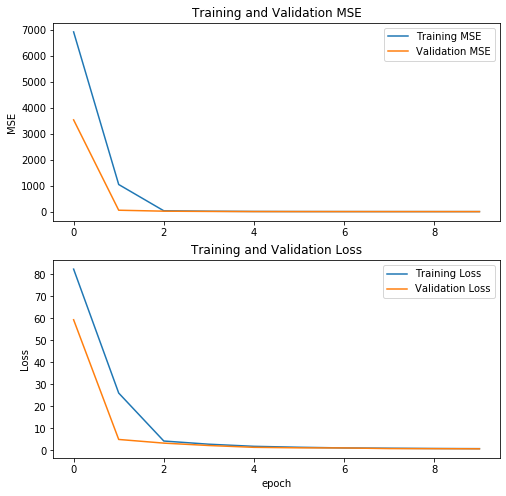

In [425]:
# Pablo Feb 25:
# Python never implicitly copies objects. When you set list2 = list1, you are making them refer to the same exact
# list object, so when you mutate it, all references to it keep referring to the object in its current state.
mae = history.history['mse'].copy()
val_mae = history.history['val_mse'].copy()

loss = history.history['loss'].copy()
val_loss = history.history['val_loss'].copy()

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MSE')
plt.plot(val_mae, label='Validation MSE')
plt.legend(loc='upper right')
plt.ylabel('MSE')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation MSE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [426]:
base_model.trainable = True

# Pablo Feb 25: me aseguro que las capas que a continuación *no* pongo como trainable (layer.trainable = False) sean
# trainable.
l = 1
for layer in base_model.layers:
    print('layer {:3d}, name: {}'.format(l, layer.name))
    layer.trainable =  True
    l += 1

layer   1, name: input_8
layer   2, name: block1_conv1
layer   3, name: block1_conv2
layer   4, name: block1_pool
layer   5, name: block2_conv1
layer   6, name: block2_conv2
layer   7, name: block2_pool
layer   8, name: block3_conv1
layer   9, name: block3_conv2
layer  10, name: block3_conv3
layer  11, name: block3_pool
layer  12, name: block4_conv1
layer  13, name: block4_conv2
layer  14, name: block4_conv3
layer  15, name: block4_pool
layer  16, name: block5_conv1
layer  17, name: block5_conv2
layer  18, name: block5_conv3
layer  19, name: block5_pool


In [427]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards

# fine_tune_at = 281 # InceptionV3, fine-tuning
# fine_tune_at = 102 # InceptionV3, not so fine-tuning
fine_tune_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  19


### Compile the model

Compile the model using a much lower learning rate.

In [428]:
# This function keeps the learning rate at 0.001 for the first ten epochs
# and decreases it exponentially after that.
def lr_scheduler(epoch):
    lr = base_learning_rate
    #k = 0.15
    #if epoch >= 10 and epoch <= 40:
    #    lr = tf.math.exp(k * (10 - epoch)) * base_learning_rate
    #    print("\nlearning rate: %.8f"%(lr))
    if epoch >= 10 and epoch <= 30:
        lr = base_learning_rate/10
    elif epoch > 30 and epoch <= 60:
        lr = base_learning_rate/100
    elif epoch > 60:
        lr = base_learning_rate/500
    print("\nlearning rate: %.6f"%(lr))
    
    return lr
    
    
callbackLR = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [429]:
# optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10, momentum=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10, epsilon=1e-08, amsgrad=True)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer = optimizer,
              metrics=['mse'])

In [430]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 14,977,857
Trainable params: 12,062,209
Non-trainable params: 2,915,648
_________________________________________________________________


In [431]:
len(model.trainable_variables)

14

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [432]:
fine_tune_epochs = 100
total_epochs =  (history.epoch[-1]+1) + fine_tune_epochs

history_fine = model.fit(tmp_train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1]+1,
                         validation_data=tmp_validation_batches,
                         callbacks=[callbackObj, callbackLR])


learning rate: 0.000100
Epoch 11/110
     40/Unknown - 6s 143ms/step - loss: 4.4334 - mse: 113.3751
New peak val_mae reached: 0.7625
./tmp/saved_models/1588128722.h5
40/40 [==============================] - 7s 169ms/step - loss: 4.4347 - mse: 113.3751 - val_loss: 0.7625 - val_mse: 0.6654

learning rate: 0.000100
Epoch 12/110
39/40 [============================>.] - ETA: 0s - loss: 0.3478 - mse: 0.3379
New peak val_mae reached: 0.1947
./tmp/saved_models/1588128728.h5
40/40 [==============================] - 6s 155ms/step - loss: 0.3449 - mse: 0.3350 - val_loss: 0.1947 - val_mse: 0.1046

learning rate: 0.000100
Epoch 13/110
40/40 [==============================] - 6s 149ms/step - loss: 0.2786 - mse: 0.2727 - val_loss: 0.2338 - val_mse: 0.0972

learning rate: 0.000100
Epoch 14/110
40/40 [==============================] - 6s 152ms/step - loss: 0.2797 - mse: 0.2491 - val_loss: 0.2544 - val_mse: 0.1157

learning rate: 0.000100
Epoch 15/110
40/40 [==============================] - 6s 151ms/s

40/40 [==============================] - 6s 151ms/step - loss: 0.0255 - mse: 0.0095 - val_loss: 0.1892 - val_mse: 0.0910

learning rate: 0.000010
Epoch 58/110
40/40 [==============================] - 6s 151ms/step - loss: 0.0243 - mse: 0.0095 - val_loss: 0.1965 - val_mse: 0.0895

learning rate: 0.000010
Epoch 59/110
40/40 [==============================] - 6s 152ms/step - loss: 0.0206 - mse: 0.0092 - val_loss: 0.1962 - val_mse: 0.0897

learning rate: 0.000010
Epoch 60/110
40/40 [==============================] - 6s 151ms/step - loss: 0.0215 - mse: 0.0090 - val_loss: 0.1909 - val_mse: 0.0910

learning rate: 0.000010
Epoch 61/110
40/40 [==============================] - 6s 151ms/step - loss: 0.0190 - mse: 0.0089 - val_loss: 0.1912 - val_mse: 0.0894

learning rate: 0.000002
Epoch 62/110
40/40 [==============================] - 6s 152ms/step - loss: 0.0159 - mse: 0.0087 - val_loss: 0.1923 - val_mse: 0.0894

learning rate: 0.000002
Epoch 63/110
40/40 [==============================] - 6s 15

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [433]:
print(history_fine.epoch)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


In [434]:
mae += history_fine.history['mse']
val_mae += history_fine.history['val_mse']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [435]:
mae = mae[1:]
val_mae = val_mae[1:]
loss = loss[1:]
val_loss = val_loss[1:]

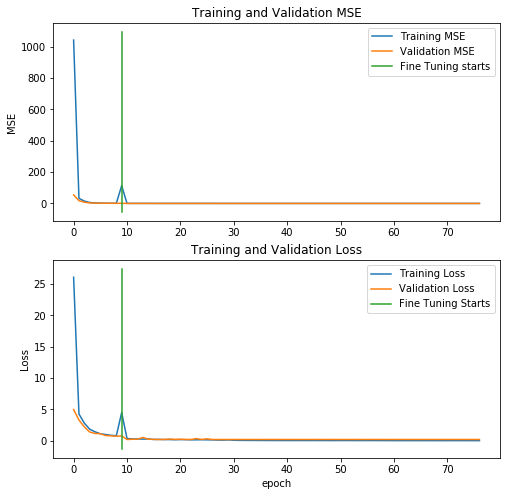

In [436]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MSE')
plt.plot(val_mae, label='Validation MSE')
#plt.ylim([0, 40])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Fine Tuning starts')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.title('Training and Validation MSE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 2000])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Fine Tuning Starts')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.


In [437]:
# Load de model and change learning rate
reloaded_model = tf.keras.models.load_model(callbackObj.saved_model_file)
print('Model {} loaded'.format(callbackObj.saved_model_file))

Model ./tmp/saved_models/1588128880.h5 loaded


In [438]:
# Evaluate the reloaded model on the train set which differs from values reported during training
loss, mae = reloaded_model.evaluate(tmp_train_batches, verbose=2)
print("Reloaded model, train loss: {:5.4f}".format(loss))
print('Reloaded model, train mae: {:5.4f}'.format(mae))

Reloaded model, train loss: 0.0439
Reloaded model, train mae: 0.0139


In [439]:
#result_batch = model.predict(tmp_train_batches)
#reloaded_result_batch = reloaded_model.predict(tmp_train_batches)
#print(abs(reloaded_result_batch - result_batch).max())
#np.testing.assert_allclose(result_batch, reloaded_result_batch, rtol=1e-6, atol=1e-6)

In [440]:
# projects out just the first two components.
if not donottest:
    tmp_test_batches = test_batches.map(lambda image, gamma, filename: (image, gamma))
    print(tmp_test_batches)

    # Evaluate the reloaded model on the test set
    loss, mae = reloaded_model.evaluate(tmp_test_batches, verbose=1)
    print("\n\nReloaded model, test loss: {:5.4f}".format(loss))
    print('Reloaded model, test mae: {:5.4f}'.format(mae))